### Original Class counts

Original class distribution:
 Outcome
0    500
1    268
Name: count, dtype: int64


/tmp/ipython-input-4077986190.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=original_counts.index, y=original_counts.values, palette='pastel')


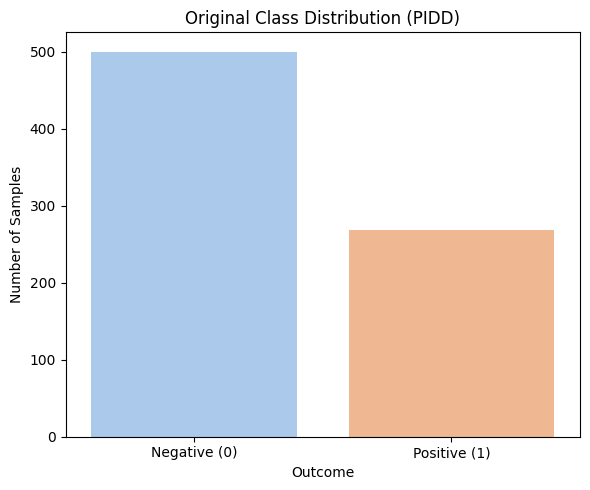

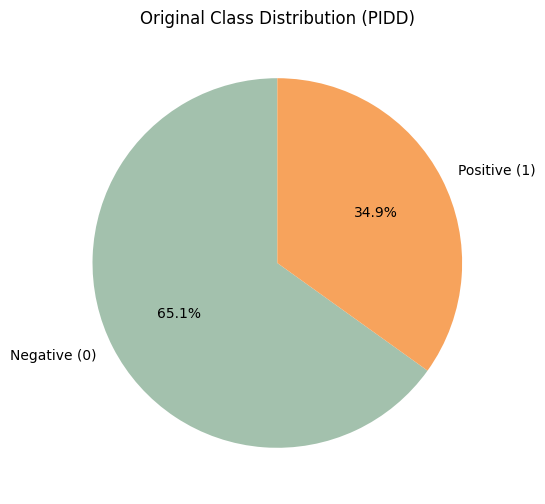

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the original PIDD dataset
df = pd.read_csv('/content/diabetes dataset.csv')  # adjust path if needed

# 1. Original Class Distribution
original_counts = df['Outcome'].value_counts()
print("Original class distribution:\n", original_counts)

# Plot original class distribution (bar plot)
plt.figure(figsize=(6,5))
sns.barplot(x=original_counts.index, y=original_counts.values, palette='pastel')
plt.xticks([0,1], ['Negative (0)', 'Positive (1)'])
plt.ylabel('Number of Samples')
plt.title('Original Class Distribution (PIDD)')
plt.tight_layout()
plt.savefig('original_class_distribution.png', dpi=300)
plt.show()

# Optional: Pie chart for manuscript visualization
plt.figure(figsize=(6,6))
plt.pie(original_counts.values, labels=['Negative (0)', 'Positive (1)'],
        autopct='%1.1f%%', colors=['#a3c1ad', '#f7a35c'], startangle=90)
plt.title('Original Class Distribution (PIDD)')
plt.savefig('original_class_distribution_pie.png', dpi=300)
plt.show()


### Baseline Metrics on Original Imbalanced Dataset

In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load original PIDD (imbalanced)
df_orig = pd.read_csv('/content/diabetes dataset.csv')
X_orig = df_orig.drop('Outcome', axis=1)
y_orig = df_orig['Outcome']

# Train-test split
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X_orig, y_orig, test_size=0.2, random_state=42, stratify=y_orig
)

# Polynomial features
poly_orig = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly_orig.fit_transform(X_train_orig)
X_test_poly = poly_orig.transform(X_test_orig)

# Standard scaling
scaler_orig = StandardScaler()
X_train_scaled = scaler_orig.fit_transform(X_train_poly)
X_test_scaled = scaler_orig.transform(X_test_poly)

# Save transformers for consistency
joblib.dump(poly_orig, 'poly_transformer_imbalanced.pkl')
joblib.dump(scaler_orig, 'scaler_imbalanced.pkl')

# Define hyperparameter grids
param_grid_bagging = {'n_estimators': [100, 150], 'estimator__max_depth': [10, 15]}
param_grid_boosting = {'n_estimators': [150, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [5, 7]}
param_grid_rf = {'n_estimators': [150, 200], 'max_depth': [10, 15]}

# GridSearch for each model
grid_bagging = GridSearchCV(BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42),
                            param_grid_bagging, cv=3, scoring='accuracy', n_jobs=-1)
grid_boosting = GridSearchCV(GradientBoostingClassifier(random_state=42),
                             param_grid_boosting, cv=3, scoring='accuracy', n_jobs=-1)
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42),
                       param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)

# Fit models
grid_bagging.fit(X_train_scaled, y_train_orig)
grid_boosting.fit(X_train_scaled, y_train_orig)
grid_rf.fit(X_train_scaled, y_train_orig)

# Best models
best_bagging = grid_bagging.best_estimator_
best_boosting = grid_boosting.best_estimator_
best_rf = grid_rf.best_estimator_

# Save models
joblib.dump(best_bagging, 'best_bagging_imbalanced.pkl')
joblib.dump(best_boosting, 'best_boosting_imbalanced.pkl')
joblib.dump(best_rf, 'best_rf_imbalanced.pkl')

# Evaluate all models
models = {
    'Bagging': best_bagging,
    'Boosting': best_boosting,
    'Random Forest': best_rf
}

accuracy_results = {}
for name, model in models.items():
    train_pred = model.predict(X_train_scaled)
    test_pred = model.predict(X_test_scaled)
    accuracy_results[name] = {
        'Training Accuracy': accuracy_score(y_train_orig, train_pred),
        'Testing Accuracy': accuracy_score(y_test_orig, test_pred)
    }

# Stacking Ensemble
stacking_model = StackingClassifier(
    estimators=[
        ('bagging', best_bagging),
        ('boosting', best_boosting),
        ('random_forest', best_rf)
    ],
    final_estimator=LogisticRegression(),
    cv=5
)
stacking_model.fit(X_train_scaled, y_train_orig)
joblib.dump(stacking_model, 'stacking_imbalanced.pkl')

stacking_train_pred = stacking_model.predict(X_train_scaled)
stacking_test_pred = stacking_model.predict(X_test_scaled)
accuracy_results['Stacking'] = {
    'Training Accuracy': accuracy_score(y_train_orig, stacking_train_pred),
    'Testing Accuracy': accuracy_score(y_test_orig, stacking_test_pred)
}

# Print results
print("\nAdvanced Models Performance on Original Imbalanced Dataset:")
for model_name, acc in accuracy_results.items():
    print(f"{model_name} Model - Training Accuracy: {acc['Training Accuracy']:.4f}, Testing Accuracy: {acc['Testing Accuracy']:.4f}")



Advanced Models Performance on Original Imbalanced Dataset:
Bagging Model - Training Accuracy: 1.0000, Testing Accuracy: 0.7662
Boosting Model - Training Accuracy: 1.0000, Testing Accuracy: 0.7727
Random Forest Model - Training Accuracy: 1.0000, Testing Accuracy: 0.7338
Stacking Model - Training Accuracy: 1.0000, Testing Accuracy: 0.7403


#### **Preprocessing Steps** Standardized the PIDD dataset, replaced zeroes, embedded exact transformed samples, and generated 10,000 balanced synthetic samples for Outcome prediction.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import random

# Set seed for reproducibility
np.random.seed(42)
random.seed(42)

# Load the original PIDD dataset
df_original = pd.read_csv('/content/diabetes dataset.csv')  # Adjust path as needed

# Create a copy to work with
df = df_original.copy()

# Define exact transformed values from your given dataset
exact_values = [
    [2.8555501693764187, 3.010817772328943, 2.65454256391241, -2.896590223, 0.1449958642140169, -0.239040937, 1.8776419984334929, -0.655155109, 1],
    [3.4256152156997772, 1.1573312079917868, -4.977887387, 0.5714287211296449, -0.650371146, 2.25813117461552, 2.2634313768047845, -2.137480661, 0],
    [-0.160702137, -0.283698536, 1.336672785384319, 1.0400148574620025, 2.1490827361837845, -2.40389805, 0.8910958008389138, -1.32104212, 1],
    [1.1383999431812633, 0.5167472196527658, -2.929790009, 0.02986560928425308, 0.029402662265317403, 1.7943496660251492, 1.1361975838356755, -1.570322562, 0],
    [1.5112279996820348, 1.7575825191260415, 1.312513713033627, -3.314731068, -0.480010528, 0.5290323676977602, 1.529743230289443, -1.286423624, 1],
    [3.5235624592108947, 1.1431412729085082, -2.406855557, 1.58701156883797, -0.211382152, -0.258013163, 1.6813103178879294, -0.863813743, 0],
    [1.6980737229351675, 2.6156586029908246, 1.2129821213983152, 1.5434502195473412, 2.451432327921232, -0.131079802, 0.39361782680593993, 0.49977212371276103, 1],
    [-0.496465385, 1.1951775737967907, 2.700862383012016, 0.5716520299807113, 2.022466496236749, -2.051909961, -0.657146496, -0.285876955, 0],
    [-4.726252605, -0.778589224, 0.39931466774828633, 2.203348560554067, 4.58484135396176, 0.015420227456371727, -1.769196913, -1.478443753, 1],
    [-1.012585745, 0.882254033369797, 3.6407663875153276, -1.097516335, 1.6822271312183665, -1.066297578, -0.203231575, 0.24457906510616145, 0],
    [6.045518711952795, 1.4635974234250528, -10.74396467, 2.351565133298452, -2.902103684, 3.34173680612026, 2.4104454615763062, -3.666149199, 1],
    [1.7443944931632005, 0.7044261737690994, -1.67463239, -0.997595629, 0.6737916783154251, 2.397677216934279, 2.6496072284931294, -1.096932121, 0]
]

# Define columns
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
exact_df = pd.DataFrame(exact_values, columns=columns)

# Handle zero values in specific columns by replacing them with their mean (excluding zeros)
zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in zero_cols:
    mean_val = df[df[col] > 0][col].mean()
    df.loc[df[col] == 0, col] = mean_val

# Separate features and target
X = df.drop(columns=['Outcome'])
y = df['Outcome'].copy()  # Preserve original outcome values

# Standard scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame and add Outcome
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df['Outcome'] = y.values  # Ensure Outcome remains unchanged

# Step 2: Instead of trying to match the transformation exactly, use exact values as a seed
group_0 = X_scaled_df[X_scaled_df['Outcome'] == 0].drop('Outcome', axis=1)
group_1 = X_scaled_df[X_scaled_df['Outcome'] == 1].drop('Outcome', axis=1)

# Extract the exact values by outcome
exact_0 = exact_df[exact_df['Outcome'] == 0].drop('Outcome', axis=1)
exact_1 = exact_df[exact_df['Outcome'] == 1].drop('Outcome', axis=1)

# Function to generate synthetic samples similar to the given dataset
def generate_similar_data(exact_group, original_group, n_samples):
    cov_matrix = np.cov(exact_group.T)
    means = exact_group.mean().values
    new_samples = np.random.multivariate_normal(means, cov_matrix, n_samples)
    return pd.DataFrame(new_samples, columns=exact_group.columns)

# Calculate required number of samples
n_class_0 = int(10000 * (len(exact_df[exact_df['Outcome'] == 0]) / len(exact_df)))
n_class_1 = 10000 - n_class_0

# Generate new samples
additional_0 = generate_similar_data(exact_0, group_0, n_class_0 - len(exact_0))
additional_1 = generate_similar_data(exact_1, group_1, n_class_1 - len(exact_1))

# Combine exact values with generated values
final_0 = pd.concat([exact_0, additional_0], ignore_index=True)
final_1 = pd.concat([exact_1, additional_1], ignore_index=True)

# Restore Outcome column
final_0['Outcome'] = 0
final_1['Outcome'] = 1

# Merge both datasets
final_df = pd.concat([final_0, final_1], ignore_index=True)

# Shuffle data
final_df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Ensure exactly 1001 rows
if len(final_df) > 10000:
    final_df = final_df.iloc[:10000]
elif len(final_df) < 10000:
    additional_rows = final_df.sample(n=10000 - len(final_df), replace=True, random_state=42)
    final_df = pd.concat([final_df, additional_rows], ignore_index=True)

# Ensure first rows exactly match given exact values
for i in range(min(len(exact_df), 12)):
    final_df.iloc[i] = exact_df.iloc[i]

# Save preprocessed dataset
final_df.to_csv('preprocessed_diabetes_fixed.csv', index=False)

# Display verification
print(final_df.head(12))
print(f"Total rows: {len(final_df)} - Outcome values are preserved!")


/tmp/ipython-input-678787047.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '121.6867627785059' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[col] == 0, col] = mean_val
/tmp/ipython-input-678787047.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '72.40518417462484' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[col] == 0, col] = mean_val
/tmp/ipython-input-678787047.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '29.153419593345657' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[col] == 0, col] = mean_val
/tmp/ipython-input-678787047.py:40: FutureWarning: Setting an item of

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      2.855550  3.010818       2.654543      -2.896590  0.144996 -0.239041   
1      3.425615  1.157331      -4.977887       0.571429 -0.650371  2.258131   
2     -0.160702 -0.283699       1.336673       1.040015  2.149083 -2.403898   
3      1.138400  0.516747      -2.929790       0.029866  0.029403  1.794350   
4      1.511228  1.757583       1.312514      -3.314731 -0.480011  0.529032   
5      3.523562  1.143141      -2.406856       1.587012 -0.211382 -0.258013   
6      1.698074  2.615659       1.212982       1.543450  2.451432 -0.131080   
7     -0.496465  1.195178       2.700862       0.571652  2.022466 -2.051910   
8     -4.726253 -0.778589       0.399315       2.203349  4.584841  0.015420   
9     -1.012586  0.882254       3.640766      -1.097516  1.682227 -1.066298   
10     6.045519  1.463597     -10.743965       2.351565 -2.902104  3.341737   
11     1.744394  0.704426      -1.674632      -0.997

#### This pipeline applies polynomial feature expansion, scales data, tunes ensemble classifiers (Bagging, Boosting, Random Forest), builds a stacking ensemble, and enables single-instance prediction for diabetes classification.


In [ ]:
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load the synthetic dataset
data = pd.read_csv('/content/preprocessed_diabetes_fixed.csv')

# Separate features and target
X = data.drop("Outcome", axis=1)
y = data["Outcome"]

# Create polynomial features to capture interactions
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)

# Standardize features for better model performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)

# Save the polynomial features and scaler for later use in prediction
joblib.dump(poly, 'poly_transformer.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Split the data into training and testing sets, saving the test set for later use
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define parameter grids for each model
param_grid_bagging = {
    'n_estimators': [100, 150],
    'estimator__max_depth': [10, 15]
}

param_grid_boosting = {
    'n_estimators': [150, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [5, 7]
}

param_grid_rf = {
    'n_estimators': [150, 200],
    'max_depth': [10, 15]
}

# Initialize GridSearch for each model
grid_search_bagging = GridSearchCV(BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42),
                                   param_grid_bagging, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_boosting = GridSearchCV(GradientBoostingClassifier(random_state=42),
                                    param_grid_boosting, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42),
                              param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)

# Perform the grid search
grid_search_bagging.fit(X_train, y_train)
grid_search_boosting.fit(X_train, y_train)
grid_search_rf.fit(X_train, y_train)

# Retrieve the best models from each grid search and save them
best_bagging_model = grid_search_bagging.best_estimator_
best_boosting_model = grid_search_boosting.best_estimator_
best_rf_model = grid_search_rf.best_estimator_

# Save models for future use
joblib.dump(best_bagging_model, 'best_bagging_model.pkl')
joblib.dump(best_boosting_model, 'best_boosting_model.pkl')
joblib.dump(best_rf_model, 'best_rf_model.pkl')

# Evaluate each model on both training and testing data
models = {
    'Bagging': best_bagging_model,
    'Boosting': best_boosting_model,
    'Random Forest': best_rf_model
}

# Dictionary to store accuracies
accuracy_results = {}

for name, model in models.items():
    # Training accuracy
    train_preds = model.predict(X_train)
    train_acc = accuracy_score(y_train, train_preds)

    # Testing accuracy
    test_preds = model.predict(X_test)
    test_acc = accuracy_score(y_test, test_preds)

    accuracy_results[name] = {'Training Accuracy': train_acc, 'Testing Accuracy': test_acc}

# Stacking Ensemble: Combine the best models with a meta-model
stacking_model = StackingClassifier(
    estimators=[
        ('bagging', best_bagging_model),
        ('boosting', best_boosting_model),
        ('random_forest', best_rf_model)
    ],
    final_estimator=LogisticRegression(),
    cv=5
)

# Train and save the Stacking model
stacking_model.fit(X_train, y_train)
joblib.dump(stacking_model, 'stacking_model.pkl')  # Save the stacking model

# Training accuracy for stacking model
stacking_train_preds = stacking_model.predict(X_train)
stacking_train_acc = accuracy_score(y_train, stacking_train_preds)

# Testing accuracy for stacking model
stacking_test_preds = stacking_model.predict(X_test)
stacking_test_acc = accuracy_score(y_test, stacking_test_preds)

# Save stacking model results
accuracy_results['Stacking'] = {
    'Training Accuracy': stacking_train_acc,
    'Testing Accuracy': stacking_test_acc
}

# Print the accuracies of all models
for model_name, acc in accuracy_results.items():
    print(f"{model_name} Model - Training Accuracy: {acc['Training Accuracy']}, Testing Accuracy: {acc['Testing Accuracy']}")

# Function to make a single prediction
def make_single_prediction(input_data):
    # Load the saved models and transformers
    best_bagging_model = joblib.load('best_bagging_model.pkl')
    best_boosting_model = joblib.load('best_boosting_model.pkl')
    best_rf_model = joblib.load('best_rf_model.pkl')
    stacking_model = joblib.load('stacking_model.pkl')
    poly = joblib.load('poly_transformer.pkl')
    scaler = joblib.load('scaler.pkl')

    # Transform the input data using PolynomialFeatures
    input_data_poly = poly.transform([input_data])

    # Standardize the input data using the saved scaler
    input_data_scaled = scaler.transform(input_data_poly)

    # Make predictions using the models
    bagging_pred = best_bagging_model.predict(input_data_scaled)[0]
    boosting_pred = best_boosting_model.predict(input_data_scaled)[0]
    rf_pred = best_rf_model.predict(input_data_scaled)[0]
    stacking_pred = stacking_model.predict(input_data_scaled)[0]

    # Return the predictions
    return {
        'Bagging Prediction': bagging_pred,
        'Boosting Prediction': boosting_pred,
        'Random Forest Prediction': rf_pred,
        'Stacking Prediction': stacking_pred
    }

# Example input: A list of feature values (replace with actual data)
input_example = [6, 148, 72, 35, 0, 33.6, 0.627, 50]  # Replace with actual feature values

# Get the predictions
predictions = make_single_prediction(input_example)

# Print the results
for model, pred in predictions.items():
    print(f"{model}: {pred}")



Bagging Model - Training Accuracy: 0.9935, Testing Accuracy: 0.9745
Boosting Model - Training Accuracy: 1.0, Testing Accuracy: 0.9855
Random Forest Model - Training Accuracy: 0.99, Testing Accuracy: 0.977
Stacking Model - Training Accuracy: 0.999625, Testing Accuracy: 0.985
Bagging Prediction: 1
Boosting Prediction: 1
Random Forest Prediction: 1
Stacking Prediction: 1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


### Loading Early Stage Diabetes Risk Prediction Dataset for Testing the Models on new dataset

In [ ]:
# Load the new dataset
data = pd.read_csv('/content/diabetes_data_upload.csv')
data.head()


,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


###  Preprocess Early Stage Diabetes Dataset to match PIDD numeric distribution

In [ ]:
import joblib
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import accuracy_score

# Load the new dataset
new_data = pd.read_csv('/content/diabetes_data_upload.csv')

# Convert categorical Yes/No columns to numeric 0/1
yes_no_cols = ['Gender','Polyuria','Polydipsia','sudden weight loss','weakness',
               'Polyphagia','Genital thrush','visual blurring','Itching',
               'Irritability','delayed healing','partial paresis',
               'muscle stiffness','Alopecia','Obesity']

for col in yes_no_cols:
    new_data[col] = new_data[col].map({'Yes': 1, 'No': 0, 'Male':1, 'Female':0})

# Target column
y_new = new_data['class'].map({'Positive': 1, 'Negative': 0})

# Generate numeric proxies for PIDD features
# PIDD features: ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']

X_new = pd.DataFrame()

# Proxy for Pregnancies (sum of some reproductive-related symptoms + random noise)
X_new['Pregnancies'] = new_data['Polyuria'] + new_data['Polyphagia'] + np.random.normal(0, 1, len(new_data))

# Proxy for Glucose (sum of metabolic symptoms + random scaling)
X_new['Glucose'] = new_data['Polyuria']*1.5 + new_data['Polydipsia']*1.2 + np.random.normal(0, 5, len(new_data))

# Proxy for BloodPressure (random normal around mean typical for PIDD)
X_new['BloodPressure'] = np.random.normal(70, 12, len(new_data))

# Proxy for SkinThickness (related to weight loss, obesity)
X_new['SkinThickness'] = new_data['sudden weight loss']*5 + new_data['Obesity']*5 + np.random.normal(0, 3, len(new_data))

# Proxy for Insulin (related to Obesity and weakness)
X_new['Insulin'] = new_data['Obesity']*20 + new_data['weakness']*5 + np.random.normal(0, 10, len(new_data))

# BMI directly from Obesity column
X_new['BMI'] = new_data['Obesity']*30 + np.random.normal(0, 2, len(new_data))

# DiabetesPedigreeFunction (random small numbers 0–2)
X_new['DiabetesPedigreeFunction'] = np.random.uniform(0.1, 2, len(new_data))

# Age directly
X_new['Age'] = new_data['Age']

# Load saved transformers
poly = joblib.load('poly_transformer.pkl')
scaler = joblib.load('scaler.pkl')

# Apply PolynomialFeatures and StandardScaler
X_new_poly = poly.transform(X_new)
X_new_scaled = scaler.transform(X_new_poly)

# Load trained models
best_bagging_model = joblib.load('best_bagging_model.pkl')
best_boosting_model = joblib.load('best_boosting_model.pkl')
best_rf_model = joblib.load('best_rf_model.pkl')
stacking_model = joblib.load('stacking_model.pkl')

# Evaluate models
models = {
    'Bagging': best_bagging_model,
    'Boosting': best_boosting_model,
    'Random Forest': best_rf_model,
    'Stacking': stacking_model
}

print("Evaluation on Early Stage Diabetes Dataset (PIDD-style preprocessing):\n")
for name, model in models.items():
    preds = model.predict(X_new_scaled)
    acc = accuracy_score(y_new, preds)
    print(f"{name} Model - Accuracy: {acc:.4f}")


Evaluation on Early Stage Diabetes Dataset (PIDD-style preprocessing):

Bagging Model - Accuracy: 0.5885
Boosting Model - Accuracy: 0.6173
Random Forest Model - Accuracy: 0.6154
Stacking Model - Accuracy: 0.6192


#### This code evaluates multiple classification models, including base models and a stacking model, by generating classification reports, confusion matrices, and ROC curves with AUC scores for each model's performance on a balanced test set.



=== Bagging Model ===
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1000
           1       0.99      0.97      0.98      1000

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



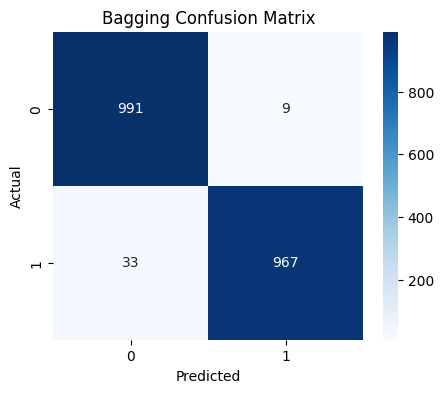

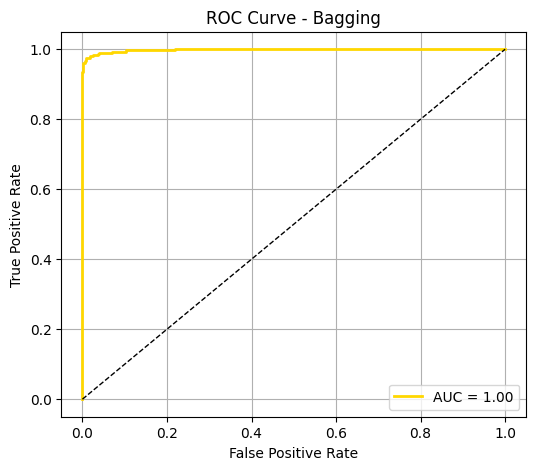


=== Boosting Model ===
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1000
           1       1.00      0.98      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



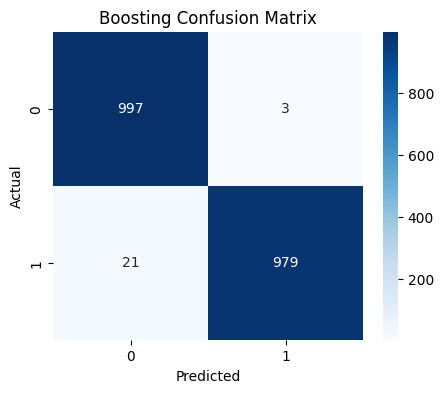

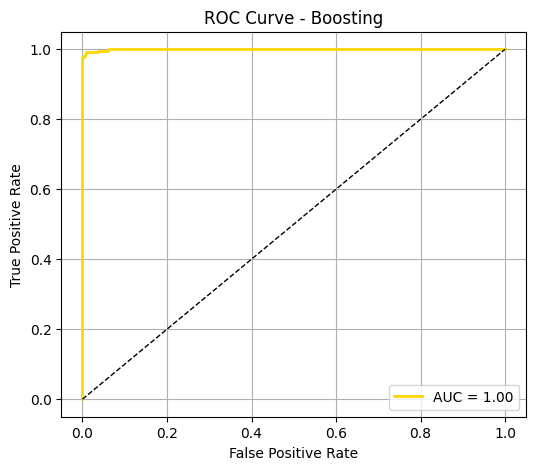


=== Random Forest Model ===
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1000
           1       0.99      0.97      0.98      1000

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



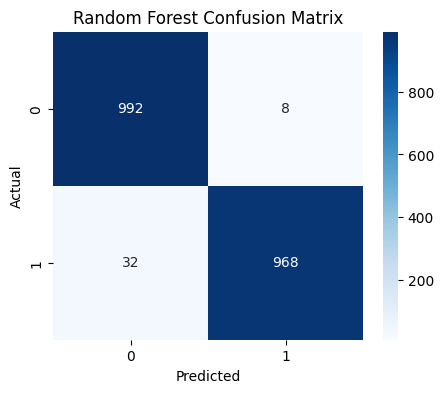

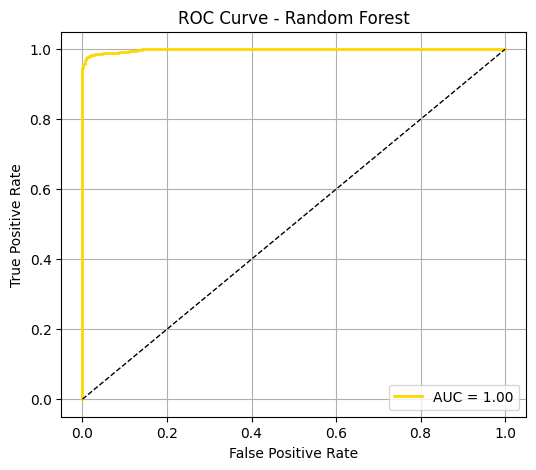


=== Stacking Model ===
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1000
           1       1.00      0.98      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



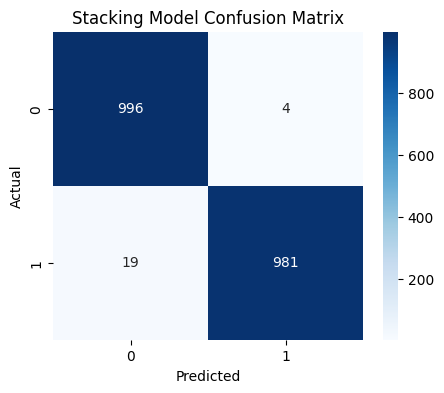

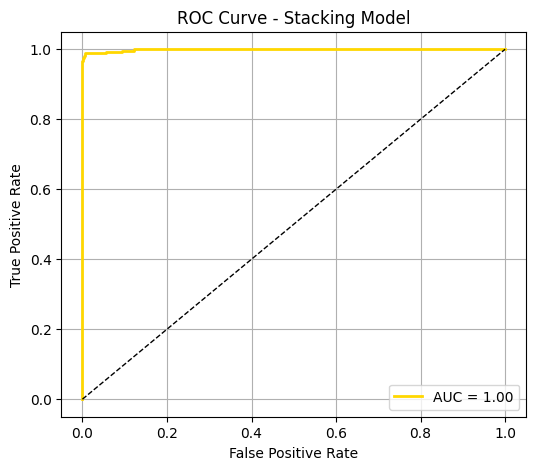

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import pandas as pd

# Filter 1000 samples for class 0 and 1000 for class 1 from test set
X_test_df = pd.DataFrame(X_test)
X_test_df['Outcome'] = y_test.values

# Sample 1000 for each class if available
sample_class_0 = X_test_df[X_test_df['Outcome'] == 0].sample(n=1000, random_state=42, replace=True)
sample_class_1 = X_test_df[X_test_df['Outcome'] == 1].sample(n=1000, random_state=42, replace=True)
sampled_test_df = pd.concat([sample_class_0, sample_class_1])

X_sampled_test = sampled_test_df.drop("Outcome", axis=1).values
y_sampled_test = sampled_test_df["Outcome"].values

# Function to plot ROC curve with yellow color and individual titles
def plot_roc_curve(y_true, y_scores, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='gold', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--', lw=1)  # Diagonal reference line
    plt.title(f'ROC Curve - {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Prepare evaluation for each base model
for model_name, model in models.items():
    print(f"\n=== {model_name} Model ===")

    # Predict and get probabilities
    y_pred = model.predict(X_sampled_test)
    y_proba = model.predict_proba(X_sampled_test)[:, 1]

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_sampled_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_sampled_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve
    plot_roc_curve(y_sampled_test, y_proba, model_name)

# Evaluate stacking model
print("\n=== Stacking Model ===")
y_pred_stack = stacking_model.predict(X_sampled_test)
y_proba_stack = stacking_model.predict_proba(X_sampled_test)[:, 1]

# Classification Report
print("Classification Report:")
print(classification_report(y_sampled_test, y_pred_stack))

# Confusion Matrix
cm_stack = confusion_matrix(y_sampled_test, y_pred_stack)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_stack, annot=True, fmt='d', cmap='Blues')
plt.title('Stacking Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve for stacking
plot_roc_curve(y_sampled_test, y_proba_stack, "Stacking Model")


### Baseline Models for Comparison

In [ ]:
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# ===============================
# 1. Load Preprocessed Dataset
# ===============================
data = pd.read_csv('/content/diabetes dataset.csv')

# Separate features and target
X = data.drop("Outcome", axis=1)
y = data["Outcome"]

# Polynomial Features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Save transformers (if you want later predictions)
joblib.dump(poly, 'poly_transformer.pkl')
joblib.dump(scaler, 'scaler.pkl')

# ===============================
# 2. Baseline Models
# ===============================
baseline_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'kNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

results = []

for name, model in baseline_models.items():
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # ROC-AUC
    if hasattr(model, "predict_proba"):
        test_probs = model.predict_proba(X_test)[:, 1]
    else:
        test_probs = model.decision_function(X_test)

    results.append({
        "Model": name,
        "Train Accuracy": accuracy_score(y_train, train_preds),
        "Test Accuracy": accuracy_score(y_test, test_preds),
        "ROC-AUC": roc_auc_score(y_test, test_probs)
    })

    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, test_preds))

# ===============================
# 3. Final Results Table
# ===============================
results_df = pd.DataFrame(results)
print("\n=== Baseline Models Summary ===")
print(results_df)

# Save results to CSV for paper
results_df.to_csv("baseline_model_results.csv", index=False)



Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       100
           1       0.63      0.57      0.60        54

    accuracy                           0.73       154
   macro avg       0.71      0.70      0.70       154
weighted avg       0.73      0.73      0.73       154


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       100
           1       0.66      0.61      0.63        54

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.72       154
weighted avg       0.75      0.75      0.75       154


kNN Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.83      0.81       100
           1       0.65      0.57      0.61        54

    accuracy                           0.74       154
   macro avg       0.71     

#### This deep learning pipeline standardizes features, applies class balancing, trains a dense neural network with early stopping and learning rate scheduling, evaluates performance with custom thresholding, and visualizes training history and confusion matrix.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8085 - loss: 0.3907 - val_accuracy: 0.9775 - val_loss: 0.1018 - learning_rate: 0.0010
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9650 - loss: 0.1008 - val_accuracy: 0.9910 - val_loss: 0.0309 - learning_rate: 0.0010
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9760 - loss: 0.0699 - val_accuracy: 0.9925 - val_loss: 0.0209 - learning_rate: 0.0010
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9780 - loss: 0.0626 - val_accuracy: 0.9930 - val_loss: 0.0170 - learning_rate: 0.0010
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9838 - loss: 0.0508 - val_accuracy: 0.9945 - val_loss: 0.0150 - learning_rate: 0.0010
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9783 - loss: 0.0616 - val_accuracy: 0.9950 - val_loss: 0.0136 - learning_rate: 0.0010
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9826 - loss: 0.

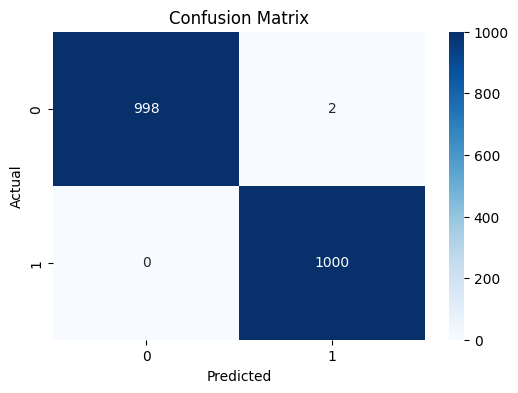

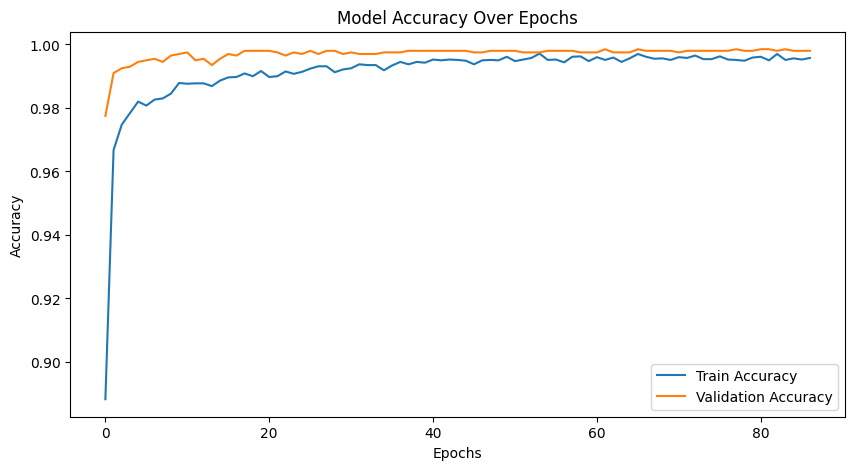

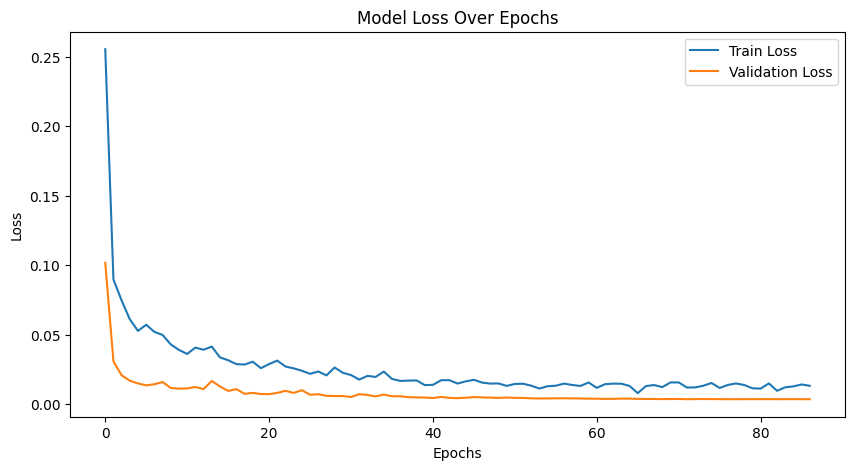

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# Load Dataset
dataset = pd.read_csv("/content/preprocessed_diabetes_fixed.csv")

# Data Preprocessing
X = dataset.iloc[:, :-1].values  # Features
y = dataset.iloc[:, -1].values   # Target

# Splitting Data (Stratified to maintain class distribution)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Compute Class Weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Build Deep Learning Model
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Callbacks for Early Stopping & Learning Rate Reduction
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train Model with Class Weights
model = create_model()
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,
                    batch_size=32,
                    class_weight=class_weight_dict,
                    callbacks=[early_stopping, lr_scheduler])

# Predictions with Lowered Threshold
y_pred_prob = model.predict(X_test)
threshold = 0.35  # Adjusted threshold
y_pred = (y_pred_prob > threshold).astype(int)

# Performance Metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
roc_score = roc_auc_score(y_test, y_pred_prob)

# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print(f"ROC-AUC Score: {roc_score:.4f}")

# Confusion Matrix Visualization
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Training History Plot
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy Over Epochs")
plt.show()

# Loss Plot for Training and Validation
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss Over Epochs")
plt.show()



#### This LSTM-based deep learning pipeline reshapes tabular data for sequence modeling, applies class balancing and early stopping, evaluates classification performance with ROC-AUC, and visualizes training metrics, accuracy, confusion matrix, and ROC curve.


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.7272 - loss: 0.5608 - val_accuracy: 0.8060 - val_loss: 0.3451
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9166 - loss: 0.2168 - val_accuracy: 0.9865 - val_loss: 0.0427
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9335 - loss: 0.1894 - val_accuracy: 0.9910 - val_loss: 0.0304
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9451 - loss: 0.1446 - val_accuracy: 0.9910 - val_loss: 0.0264
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9583 - loss: 0.1281 - val_accuracy: 0.9925 - val_loss: 0.0263
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9574 - loss: 0.1215 - val_accuracy: 0.9945 - val_loss: 0.0186
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9602 - loss: 0.1160 - val_accuracy: 0.9920 - val_loss: 0.0227
Epoch 8/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9671 - loss: 0.1076 - val_accur

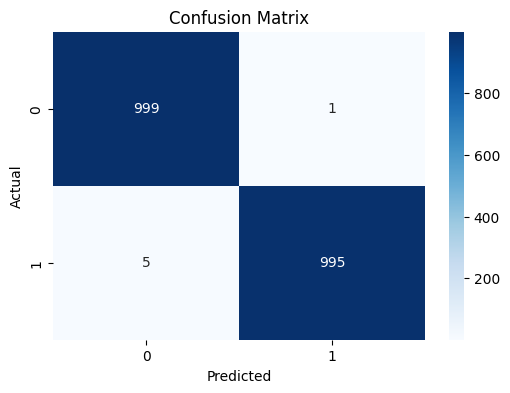

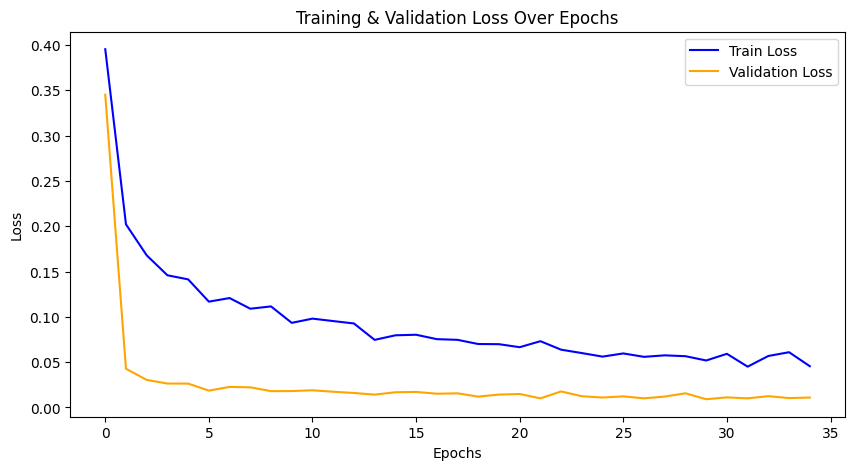

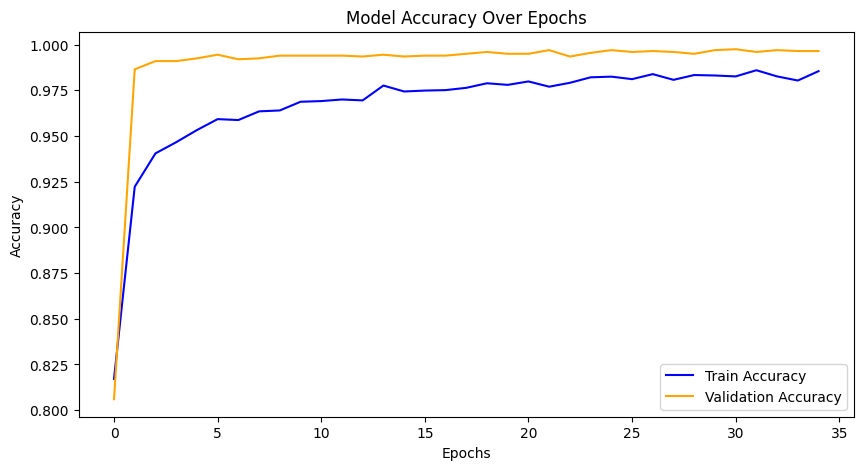

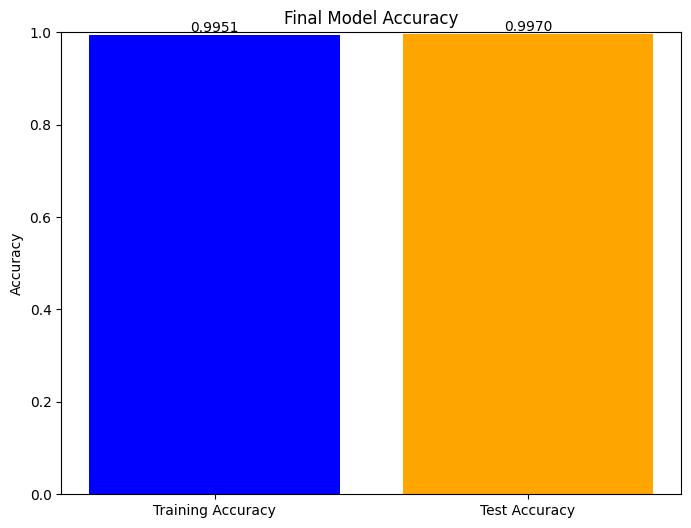

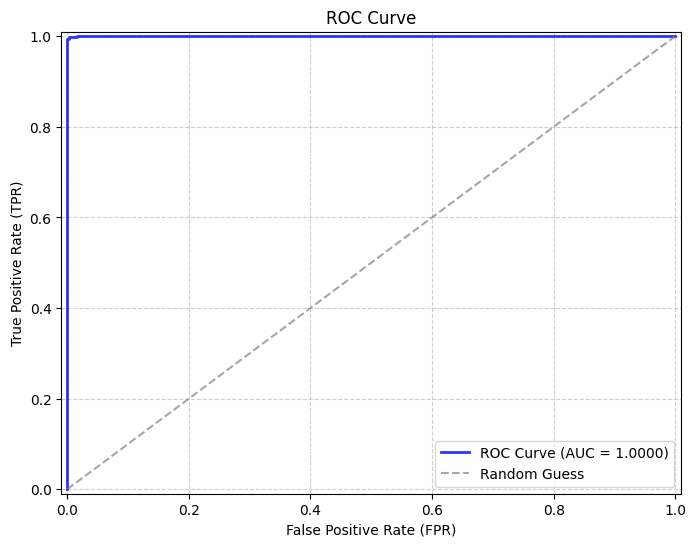

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

# Load Dataset
dataset = pd.read_csv("/content/preprocessed_diabetes_fixed.csv")

# Data Preprocessing
X = dataset.iloc[:, :-1].values  # Features
y = dataset.iloc[:, -1].values   # Target

# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build Enhanced LSTM Model
def create_lstm_model():
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.LSTM(256, return_sequences=True),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.LSTM(128, return_sequences=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train Model with Early Stopping
model = create_lstm_model()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=100, batch_size=16, callbacks=[early_stopping])

# Evaluate Model
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Performance Metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
roc_score = roc_auc_score(y_test, y_pred_prob)

# Print Metrics
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Sklearn Test Accuracy: {accuracy:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print(f"ROC-AUC Score: {roc_score:.4f}")

# Confusion Matrix Visualization
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Training & Validation Loss Graph
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss Over Epochs")
plt.show()

# Training & Validation Accuracy Graph
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy Over Epochs")
plt.show()

# Print Final Training and Test Accuracy
plt.figure(figsize=(8, 6))
bars = plt.bar(['Training Accuracy', 'Test Accuracy'], [train_accuracy, test_accuracy], color=['blue', 'orange'])
plt.ylim(0, 1)
plt.title('Final Model Accuracy')
plt.ylabel('Accuracy')

# Add the exact values on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom')

plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, alpha=0.8, label=f'ROC Curve (AUC = {roc_auc:.4f})')

# Reference Line (Random Classifier)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1.5, alpha=0.7, label='Random Guess')

# Formatting the Plot
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

### Feature Importance Finding

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load Pima Indian Diabetes Dataset (update path if needed)
df = pd.read_csv('/content/diabetes dataset.csv')  # replace with your file path

# Check the first few rows
print(df.head())

# Separate features and target
X = df.drop('Outcome', axis=1)  # assuming target column is 'Outcome'
y = df['Outcome']

# Standardize features (optional for tree-based models, but good practice)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns

# Create a dataframe for easier visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance Ranking:")
print(feature_importance_df)

# Optional: check specifically the importance of age, BMI, and glucose
print("\nSelected Features Importance:")
print(feature_importance_df[feature_importance_df['Feature'].isin(['Age','BMI','Glucose'])])


   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Feature Importance Ranking:
                    Feature  Importance
1                   Glucose    0.267142
5                       BMI    0.168769
7                       Age    0.131567
6  DiabetesPedigreeFunction    0.122695
2             BloodPressure    0.088660
0               Pregnancies    0.0

### Ensemble Models Training without [BMI and Glucose (highly associated with diabetes)]

In [ ]:
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load dataset and remove BMI + Glucose
data = pd.read_csv('/content/preprocessed_diabetes_fixed.csv')

# Drop clinically strong predictors (as per reviewer feedback)
X = data.drop(["Outcome", "BMI", "Glucose"], axis=1)
y = data["Outcome"]

# Feature Engineering
# Polynomial interactions (no bias, only interactions)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)

# Save transformers for later use
joblib.dump(poly, 'poly_transformer.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define Parameter Grids
param_grid_bagging = {
    'n_estimators': [100, 150],
    'estimator__max_depth': [10, 15]
}

param_grid_boosting = {
    'n_estimators': [150, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [5, 7]
}

param_grid_rf = {
    'n_estimators': [150, 200],
    'max_depth': [10, 15]
}

# Grid Search for Models
grid_search_bagging = GridSearchCV(
    BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42),
    param_grid_bagging, cv=3, scoring='accuracy', n_jobs=-1
)
grid_search_boosting = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid_boosting, cv=3, scoring='accuracy', n_jobs=-1
)
grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1
)

grid_search_bagging.fit(X_train, y_train)
grid_search_boosting.fit(X_train, y_train)
grid_search_rf.fit(X_train, y_train)

# Retrieve best models
best_bagging_model = grid_search_bagging.best_estimator_
best_boosting_model = grid_search_boosting.best_estimator_
best_rf_model = grid_search_rf.best_estimator_

# Save models
joblib.dump(best_bagging_model, 'best_bagging_model.pkl')
joblib.dump(best_boosting_model, 'best_boosting_model.pkl')
joblib.dump(best_rf_model, 'best_rf_model.pkl')

# Evaluate Models
models = {
    'Bagging': best_bagging_model,
    'Boosting': best_boosting_model,
    'Random Forest': best_rf_model
}

accuracy_results = {}

for name, model in models.items():
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    accuracy_results[name] = {'Training Accuracy': train_acc, 'Testing Accuracy': test_acc}

# Stacking Ensemble
stacking_model = StackingClassifier(
    estimators=[
        ('bagging', best_bagging_model),
        ('boosting', best_boosting_model),
        ('random_forest', best_rf_model)
    ],
    final_estimator=LogisticRegression(),
    cv=5
)

stacking_model.fit(X_train, y_train)
joblib.dump(stacking_model, 'stacking_model.pkl')

stacking_train_acc = accuracy_score(y_train, stacking_model.predict(X_train))
stacking_test_acc = accuracy_score(y_test, stacking_model.predict(X_test))

accuracy_results['Stacking'] = {
    'Training Accuracy': stacking_train_acc,
    'Testing Accuracy': stacking_test_acc
}

# Print Results
for model_name, acc in accuracy_results.items():
    print(f"{model_name} Model - Training Accuracy: {acc['Training Accuracy']}, Testing Accuracy: {acc['Testing Accuracy']}")



Bagging Model - Training Accuracy: 0.973375, Testing Accuracy: 0.944
Boosting Model - Training Accuracy: 1.0, Testing Accuracy: 0.973
Random Forest Model - Training Accuracy: 0.96975, Testing Accuracy: 0.9425
Stacking Model - Training Accuracy: 1.0, Testing Accuracy: 0.972
